In [78]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
import os
import json
from random import sample
from scipy.ndimage import zoom
from soma import aims
import dico_toolbox as dtb
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

In [79]:
with open('/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-07-11/11-39-50/STs_dHCP_374_supervised_results/attributions.pkl', 'rb') as f:
    gradients_dict = pickle.load(f)

# train set is whole dataset in this case
# use 0 or 1 for positive and negative classes
target = 1
gradients = gradients_dict['train'][str(target)]

In [80]:
subjects = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/Rskeleton_subject.csv')
subjects = subjects['Subject'].tolist()

In [81]:
skels = np.load("/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/Rskeleton.npy")
print(skels.shape)

(374, 22, 49, 46, 1)


In [82]:
# after Anatomist loads, run this
%matplotlib inline

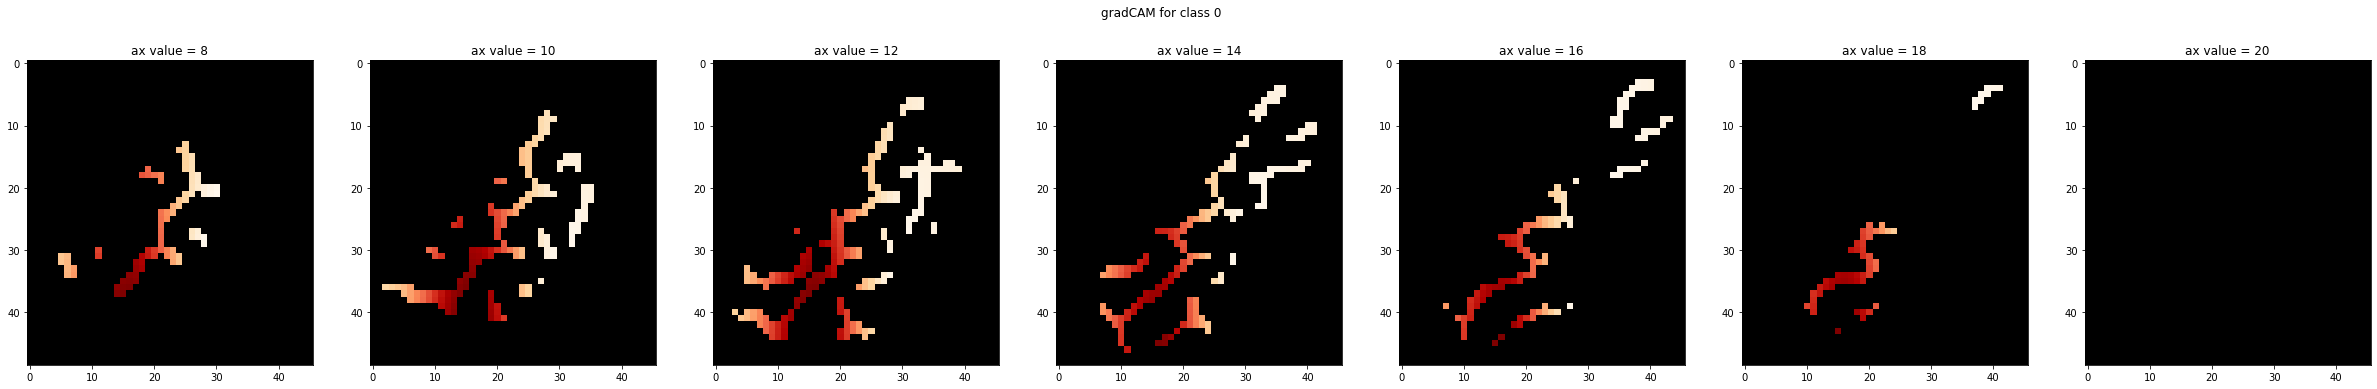

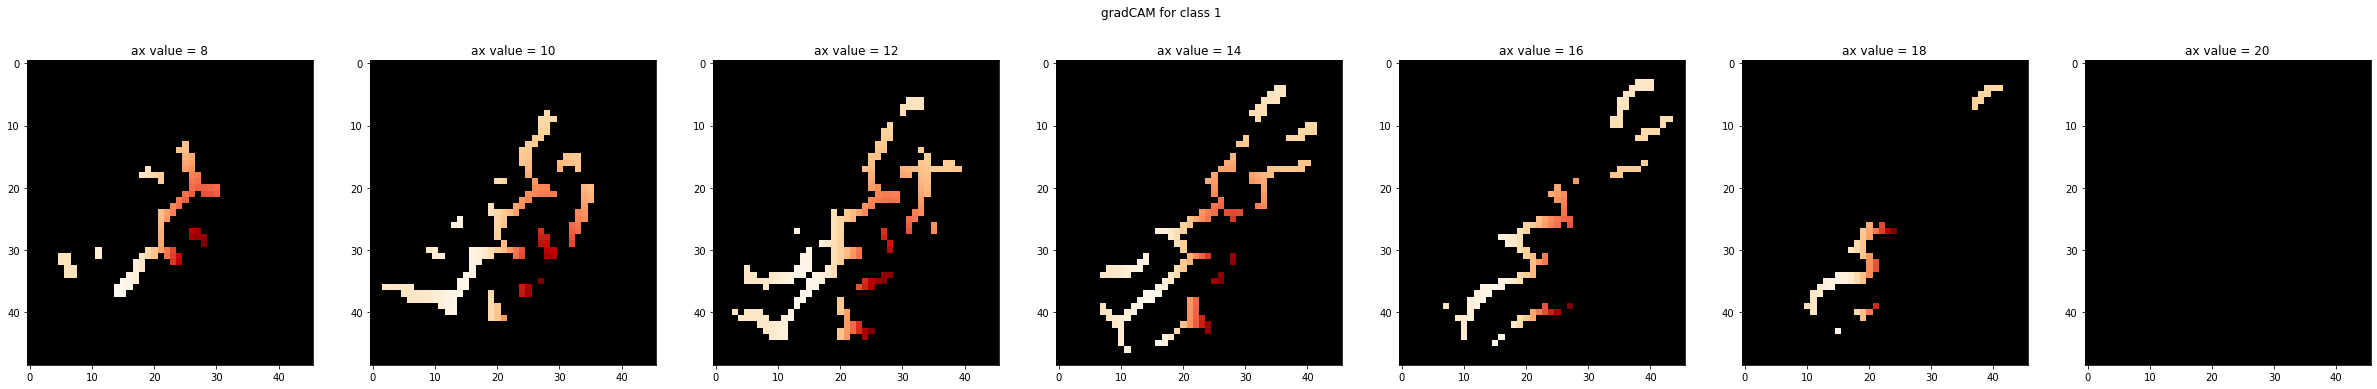

In [83]:
######################
idx = 100
plane = 0
step = 2
classes = ['0', '1'] # binary classif : need only one value
######################

skel= skels[idx]
skel = skel != 0
subject = subjects[idx]

plt.close()

cmap = mpl.cm.get_cmap("OrRd").copy()
cmap.set_bad(color='black')

for c in classes: 
    gradient = gradients_dict['train'][c][subject]
    resize_ratio = np.array(skel.shape) / np.array(gradient.shape)
    # interpolate gradient to skel dimensions, would be better to perform computation before plot
    gradient = zoom(gradient,
                    resize_ratio,
                    order=3)
    gradient_intersect = np.ma.masked_where(skel == 0, gradient)
    idxs = [*range(8, gradient.shape[plane], step)]

    fig, axs = plt.subplots(ncols=len(idxs), figsize=(6*len(idxs), 6))
    for idx, x in enumerate(idxs):
        if plane == 0:
            axs[idx].imshow(gradient_intersect[x,:,:,0], cmap=cmap)
        elif plane == 1:
            axs[idx].imshow(gradient_intersect[:,x,:,0], cmap=cmap)
        elif plane == 2:
            axs[idx].imshow(gradient_intersect[:,:,x,0], cmap=cmap)
        axs[idx].set_title(f'ax value = {x}')
    plt.suptitle(f'gradCAM for class {c}')

In [84]:
# visualize average gradient in both TP FP TN FN : but need a classif threshold ?
# 0 = fullterm
# 1 = preterm
# but inverted in predictions ? Closer to 1 = fullterm
predictions = pd.read_csv('/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-07-11/11-39-50/STs_dHCP_374_supervised_results/train_predictions.csv')

# first find good threshold
# optimize balanced accuracy
thresholds = np.linspace(0,1,1000)
accuracies = [balanced_accuracy_score(predictions['train y'], predictions['train pred'] < threshold) for threshold in thresholds]
print(f'best balanced accuracy: {max(accuracies)} \nbest threshold: {thresholds[np.argmax(accuracies)]}]')
# predictions using this threshold
preds = (predictions['train pred'] < thresholds[np.argmax(accuracies)])

best balanced accuracy: 0.8699036323202372 
best threshold: 0.9329329329329329]


In [85]:
conf_matrix = confusion_matrix(predictions['train y'], preds)
print(f'TN = {conf_matrix[0, 0]}\nFP = {conf_matrix[0, 1]}\nFN = {conf_matrix[1, 0]}\nTP = {conf_matrix[1, 1]}')

TN = 300
FP = 55
FN = 2
TP = 17


In [86]:
# check average age of each group

# Release3 dHCP : select subjects from info dataframe

dir_Release3 = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_scripts/subjects_file_v4.json'
with open(dir_Release3) as f:
    subjects_R3 = json.load(f)

subjects_R3 = list(subjects_R3.keys())

# get the session ids of R3
dir_sessions = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_scripts/subjects_file_v4.json'
with open(dir_sessions) as f:
    dict_sessions = json.load(f)
sessions = [value['session_id'] for _, value in dict_sessions.items()]

# get dHCP info
dir_info_dHCP = '/home/jl274628/Documents/info_dHCP.tsv'
info_dHCP = pd.read_csv(dir_info_dHCP, usecols=['participant_id', 'birth_age', 'scan_age', 'session_id'], sep='\t')
# filter over subjects
info_dHCP.drop(info_dHCP[~(info_dHCP['participant_id'].isin(subjects_R3))].index, inplace = True)
#info_dHCP.drop(info_dHCP[(info_dHCP['scan_number']!=1)].index, inplace = True) # not always scan 1
# filter over sessions
info_dHCP.drop(info_dHCP[~(info_dHCP['session_id'].isin(sessions))].index, inplace = True)
info_dHCP.reset_index(drop=True, inplace=True)

In [87]:
# make groups of subjects for gradient averaging
TN_subjects = np.array(subjects)[np.where((np.array(predictions['train y'])==0) & (preds==0))[0]]
FP_subjects = np.array(subjects)[np.where((np.array(predictions['train y'])==0) & (preds==1))[0]]
FN_subjects = np.array(subjects)[np.where((np.array(predictions['train y'])==1) & (preds==0))[0]]
TP_subjects = np.array(subjects)[np.where((np.array(predictions['train y'])==1) & (preds==1))[0]]

In [88]:
dict_subjects_classes = {'TN': TN_subjects,
                         'FP': FP_subjects,
                         'FN': FN_subjects,
                         'TP': TP_subjects}

In [89]:
print('Average birth_age:')
for key, value in dict_subjects_classes.items():
    age = np.mean(info_dHCP.loc[info_dHCP['participant_id'].isin(value)].birth_age)
    print(f'{key}: {age}')

Average birth_age:
TN: 38.462380952
FP: 37.92467532454545
FN: 24.571428570000002
TP: 25.789915965294117


In [90]:
print('Average scan_age:')
for key, value in dict_subjects_classes.items():
    age = np.mean(info_dHCP.loc[info_dHCP['participant_id'].isin(value)].scan_age)
    print(f'{key}: {age}')

Average scan_age:
TN: 41.23626666666667
FP: 41.30945454545454
FN: 42.57
TP: 41.33705882352941


average age is not so different between well and wrongly classified. Overfit on the specific age, very different from regresser !

In [91]:
# select subset of subjects
subset = 17

dict_subset_subjects_classes = {}
for key, value in dict_subjects_classes.items():
    val = sample(list(value), min(subset, len(value)))
    dict_subset_subjects_classes[key]=val

In [92]:
dict_average_gradients_classes = {}
for key, value in dict_subset_subjects_classes.items():
    dict_average_gradients_classes[key] = np.transpose(np.mean([gradient for (name, gradient) in gradients.items() if name in value], axis=0), (1,2,3,0))

# which smoothing used in gradcam upsampling ?
resize_ratio = np.array(skels[0].shape) / np.array(dict_average_gradients_classes['TN'].shape)
# interpolate gradient to skel dimensions
for key, value in dict_average_gradients_classes.items():
    value = zoom(value,
                resize_ratio,
                order=3)
    dict_average_gradients_classes[key] = value

In [93]:
# select the corresponding selected skels and average them
## WOULD NEED TO APPLY PHASING TO THE SKELS FIRST
threshold = 0.3
dict_average_skels_classes = {}
for key, value in dict_subset_subjects_classes.items():
    dict_average_skels_classes[key] = np.mean([(skel!=0).astype(float) for i, skel in enumerate(skels) if subjects[i] in value], axis=0) > threshold

# 2D average gradient heatmap

In [94]:
# define range for colormap normalization
mini = min([np.min(value) for key, value in dict_average_gradients_classes.items()])
maxi = max([np.max(value) for key, value in dict_average_gradients_classes.items()])
norm = plt.Normalize(mini, maxi)

Text(0.5, 0.98, 'Average gradients over plane 0')

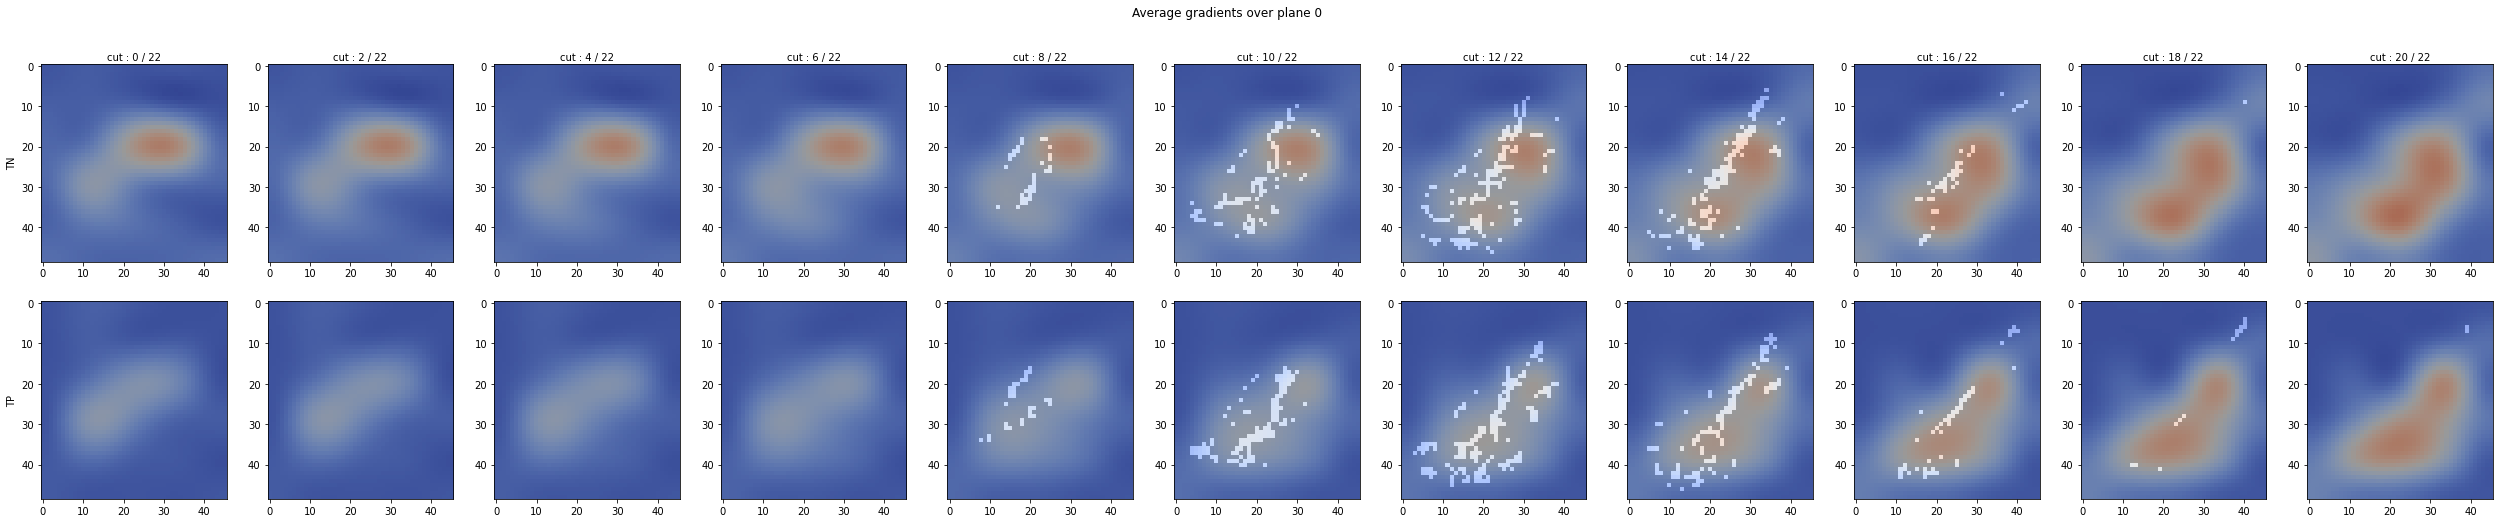

In [102]:
###########################
plane = 0
step = 2
classes = ['TN', 'TP']
###########################

maxi_range = dict_average_gradients_classes['TN'].shape[plane]
idxs = [*range(0, maxi_range, step)]


fig, axs = plt.subplots(nrows=len(classes), ncols=len(idxs), figsize=(4*len(idxs),4*len(classes)))
for i, c in enumerate(classes):
    gradient = dict_average_gradients_classes[c]
    average_skel = dict_average_skels_classes[c]
    for j, x in enumerate(idxs):
        ax = axs[i, j]

        # select right plane
        if plane == 0:
            im = gradient[x,:,:,0]
            im_skel = average_skel[x,:,:,0]
        elif plane == 1:
            im = gradient[:,x,:,0]
            im_skel = average_skel[:,x,:,0]
        elif plane == 2:
            im = gradient[:,:,x,0]
            im_skel = average_skel[:,:,x,0]
        
        # show
        ax.imshow(im_skel, cmap='gray', alpha=1)
        ax.imshow(im, cmap='coolwarm', norm=norm, alpha=0.7)

# set labels on axes
for idx, c in enumerate(classes):
    ax = axs[idx, 0]
    ax.set_ylabel(c)
for idx, x in enumerate(idxs):
    ax = axs[0, idx]
    ax.set_xlabel(f'cut : {x} / {maxi_range}')
    ax.xaxis.set_label_position('top') 

plt.suptitle(f'Average gradients over plane {plane}')

the average shows that it looks at the sulcus, but not much more: the overall gradient reaches a maximum at the level of the top ! (or bottom ? To confirm)

beware when mapping to 3D: (0,0) is at the top
NB: attention les cartes de gradients moyennes sont faites sans recalage, donc les moyennes sont diffuses et le sont d'autant plus quand la variabilité est forte. On risque de voir apparaître des diffférences entre TN et TP à cause de cela.
La carte de gradient paraît en dehors du squelette, mais cela est dû aux interpolations et au fait qu'on ne voit qu'un seul plan...

In [96]:
# individual skel dict
dict_skels_classes = {}
for key, value in dict_subset_subjects_classes.items():
    dict_skels_classes[key] = {subjects[i]: skel for i, skel in enumerate(skels) if subjects[i] in value}

In [97]:
# individual gradient dict
# NB: resize ratio defined previously
dict_gradients_classes = {}
for key, value in dict_subset_subjects_classes.items():
    dict_gradients_classes[key] = {name: zoom(np.transpose(gradient,(1,2,3,0)), resize_ratio, order=3)  for name, gradient in gradients.items() if name in value}

# 2D individual gradient maps

In [98]:
save_dir = '/home/jl274628/Documents/PLOT_RAPPORT/gradCAM/'

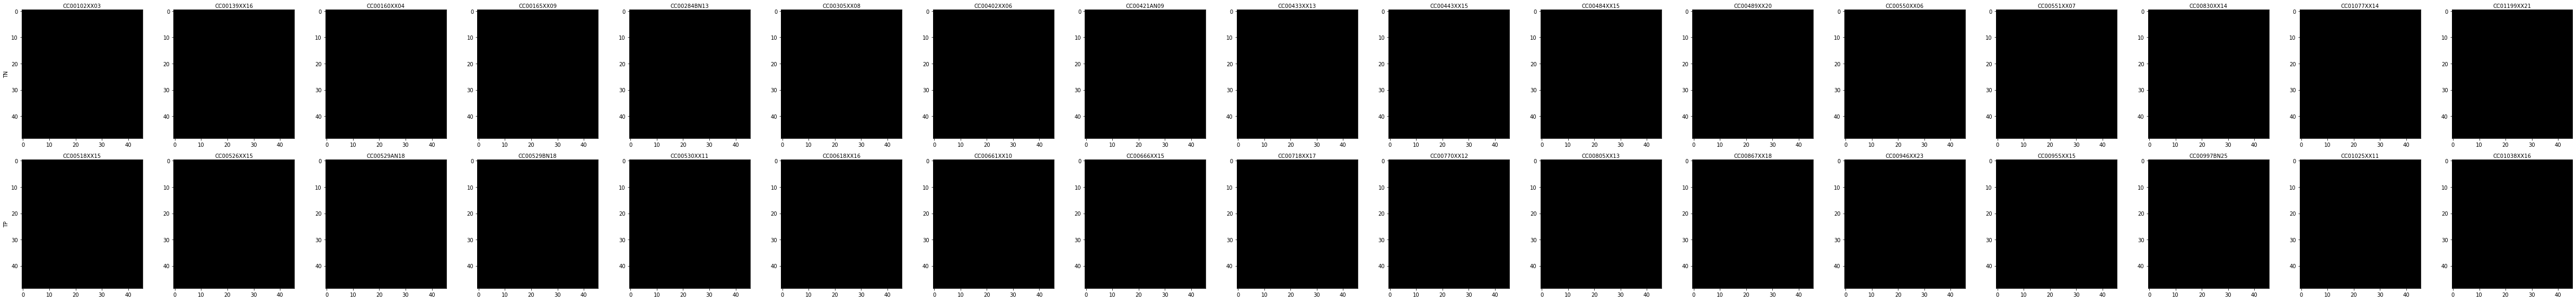

In [100]:
###########################
plane = 0
# for x in range(11, 18, 1):
#plane = 1
x = 14
#subset=17
classes = ['TN', 'TP']
###########################

cmap = mpl.cm.get_cmap("coolwarm").copy()
cmap.set_bad(color='black')


for x in range(0, 22, 1):
    plt.close()
    fig, axs = plt.subplots(nrows=len(classes), ncols=subset, figsize=(4*subset,4*len(classes)))
    for i, c in enumerate(classes):
        gradient_subjects = dict_gradients_classes[c]
        skel_subjects = dict_skels_classes[c]
        for j, name in enumerate(gradient_subjects.keys()):
            gradient, skel = gradient_subjects[name], skel_subjects[name]
            gradient_intersect = np.ma.masked_where(skel == 0, gradient)

            ax = axs[i, j]
            # select right plane
            if plane == 0:
                im = gradient_intersect[x,:,:,0]
            elif plane == 1:
                im = gradient_intersect[:,x,:,0]
            elif plane == 2:
                im = gradient_intersect[:,:,x,0]
            
            # show
            ax.imshow(im, cmap=cmap, norm=norm)
            ax.set_xlabel(name)
            ax.xaxis.set_label_position('top') # 2D individual gradient maps

    # set labels on axes
    for idx, c in enumerate(classes):
        ax = axs[idx, 0]
        ax.set_ylabel(c)

    #plt.suptitle(f'Individual samples, gradients over plane {plane}, cut = {x}')
    plt.tight_layout()

    plt.savefig(save_dir+f'target{target}/skeleton_mask/plane_{plane}/2D_gradCAM_plane_{plane}_x_{x}.png', facecolor='white')

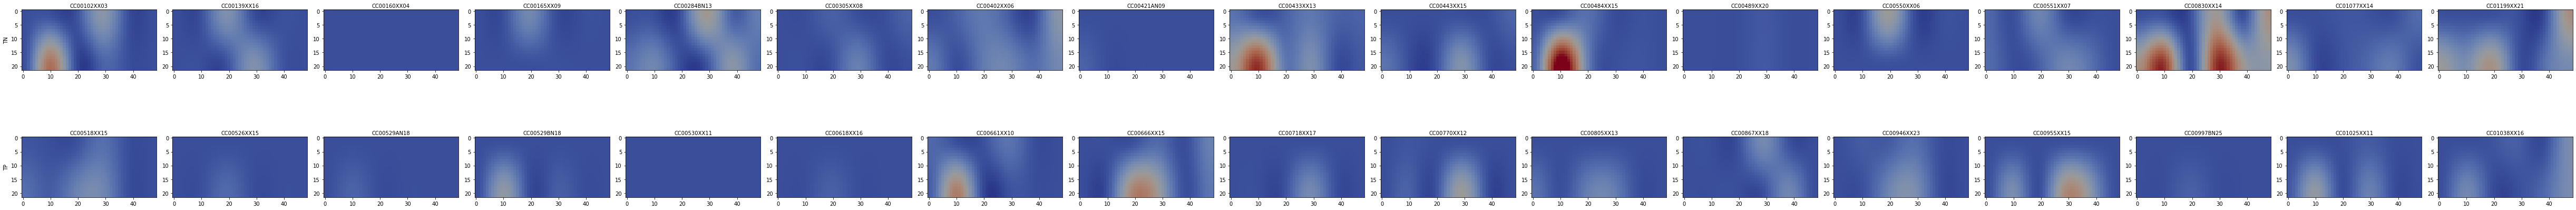

In [105]:
# do the same but without mask

###########################
plane = 1
# for x in range(11, 18, 1):
#plane = 1
#x = 14
#subset=17
classes = ['TN', 'TP']
###########################

cmap = mpl.cm.get_cmap("coolwarm").copy()
cmap.set_bad(color='black')


for x in range(22, 49, 1):
    plt.close()
    fig, axs = plt.subplots(nrows=len(classes), ncols=subset, figsize=(4*subset,4*len(classes)))
    for i, c in enumerate(classes):
        gradient_subjects = dict_gradients_classes[c]
        skel_subjects = dict_skels_classes[c]
        for j, name in enumerate(gradient_subjects.keys()):
            gradient, skel = gradient_subjects[name], skel_subjects[name]

            ax = axs[i, j]
            # select right plane
            if plane == 0:
                im = gradient[x,:,:,0]
                im_skel = skel[x,:,:,0]
            elif plane == 1:
                im = gradient[:,x,:,0]
                im_skel = skel[:,x,:,0]
            elif plane == 2:
                im = gradient[:,:,x,0]
                im_skel = skel[:,:,x,0]
            
            # show
            ax.imshow(im_skel, cmap='gray')
            ax.imshow(im, cmap=cmap, norm=norm, alpha=0.7)

            ax.set_xlabel(name)
            ax.xaxis.set_label_position('top') # 2D individual gradient maps

    # set labels on axes
    for idx, c in enumerate(classes):
        ax = axs[idx, 0]
        ax.set_ylabel(c)

    #plt.suptitle(f'Individual samples, gradients over plane {plane}, cut = {x}')
    plt.tight_layout()

    plt.savefig(save_dir+f'target{target}/without_mask/plane_{plane}/2D_gradCAM_plane_{plane}_x_{x}.png', facecolor='white')

# 3D using python

beware: sample FN is too small (2 subjects)

# 3D Anatomist: Not yet available

In [7]:
# intersect gradient with skel and save
save_dir = "/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-07-11/11-39-50/STs_dHCP_374_supervised_results/gradients/"
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
for subject, skel in zip(subjects, skels):
    print(subject)
    gradient = gradients[subject]
    resize_ratio = np.array(skel.shape) / np.array(gradient.shape)
    # interpolate gradient to skel dimensions
    gradient = zoom(gradient,
                    resize_ratio,
                    order=3)
    # center gradient so that almost null value is visible
    # mask gradient using skel
    gradient_intersect = gradient * (skel != 0)
    vol = aims.Volume(gradient_intersect)
    aims.write(vol, save_dir+f'{subject}_gradient.nii.gz')
    break

CC00065XX08


In [ ]:
# convert nifti to bucket ! : BUT HOW TO MAKE A FLOAT BUCKET ? IS IT SUPPORTED ?
"""
python3 convert_volume_to_bucket.py -s /neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-07-11/11-39-50/STs_dHCP_374_supervised_results/gradients/ -t /neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-07-11/11-39-50/STs_dHCP_374_supervised_results/gradients_buckets/
"""

In [12]:
%%capture
%gui qt
ana = dtb.anatomist.Anatomist()

In [13]:
# after Anatomist loads, run this
%matplotlib inline

In [14]:
idx=10
gradient = aims.read(save_dir+f'{subjects[idx]}_gradient.nii.gz')

In [15]:
ana.clear_quick_window()
ana(gradient, auto_color=True)
# ana.set_objects_color(meshes_shifted, color='b')

: 